<a href="https://colab.research.google.com/github/chandanams-stack/TNSIF_AIML_DBIT/blob/main/capstoneproj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [24]:
import pandas as pd
import os

file_path = "/manufacturing_dataset_1000_samples.csv"

# Check if the file exists
if os.path.exists(file_path):
    # 2. Load Dataset
    df = pd.read_csv(file_path)

    print("Shape:", df.shape)
    print(df.head())
else:
    print(f"Error: The file '{file_path}' was not found.")
    print("Please upload the dataset or provide the correct path.")

Shape: (1000, 19)
             Timestamp  Injection_Temperature  Injection_Pressure  Cycle_Time  \
0  2023-01-01 00:00:00                  221.0               136.0        28.7   
1  2023-01-01 01:00:00                  213.3               128.9        34.5   
2  2023-01-01 02:00:00                  222.8               115.9        19.9   
3  2023-01-01 03:00:00                  233.3               105.3        39.2   
4  2023-01-01 04:00:00                  212.2               125.5        45.0   

   Cooling_Time  Material_Viscosity  Ambient_Temperature  Machine_Age  \
0          13.6               375.5                 28.0          3.8   
1          14.0               215.8                 22.6          6.8   
2           9.5               307.0                 25.3          4.2   
3          13.1               137.8                 26.0          9.2   
4           9.9               298.2                 23.6          6.2   

   Operator_Experience  Maintenance_Hours    Shift Machi

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
# 3. Handle Timestamp

# Convert to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Extract features from Timestamp
df['Hour'] = df['Timestamp'].dt.hour
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month

# (Optional) Extract more useful features
df['DayOfWeek'] = df['Timestamp'].dt.day_name()   # Monday, Tuesday, etc.
df['Year'] = df['Timestamp'].dt.year              # In case dataset spans multiple years

# Drop rows with invalid/missing timestamps
df = df[df['Timestamp'].notna()]

# Drop original timestamp column if not needed
df.drop(columns=['Timestamp'], inplace=True)

# Show the updated dataframe
df.head()


,Injection_Temperature,Injection_Pressure,Cycle_Time,Cooling_Time,Material_Viscosity,Ambient_Temperature,Machine_Age,Operator_Experience,Maintenance_Hours,Shift,...,Temperature_Pressure_Ratio,Total_Cycle_Time,Efficiency_Score,Machine_Utilization,Parts_Per_Hour,Hour,Day,Month,DayOfWeek,Year
0,221.0,136.0,28.7,13.6,375.5,28.0,3.8,11.2,64,Evening,...,1.625,42.3,0.063,0.510,36.5,0,1,1,Sunday,2023
1,213.3,128.9,34.5,14.0,215.8,22.6,6.8,6.3,58,Night,...,1.655,48.5,0.037,0.389,29.9,1,1,1,Sunday,2023
2,222.8,115.9,19.9,9.5,307.0,25.3,4.2,9.6,47,Day,...,1.922,29.4,0.061,0.551,56.9,2,1,1,Sunday,2023
3,233.3,105.3,39.2,13.1,137.8,26.0,9.2,8.6,49,Evening,...,2.215,52.3,0.054,0.293,31.0,3,1,1,Sunday,2023
4,212.2,125.5,45.0,9.9,298.2,23.6,6.2,23.0,49,Night,...,1.691,54.9,0.145,0.443,15.0,4,1,1,Sunday,2023


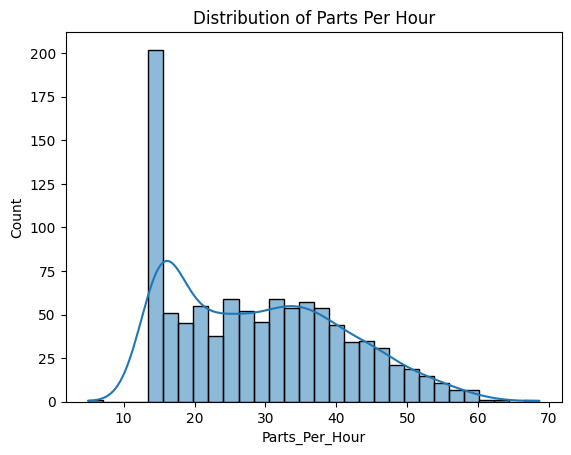

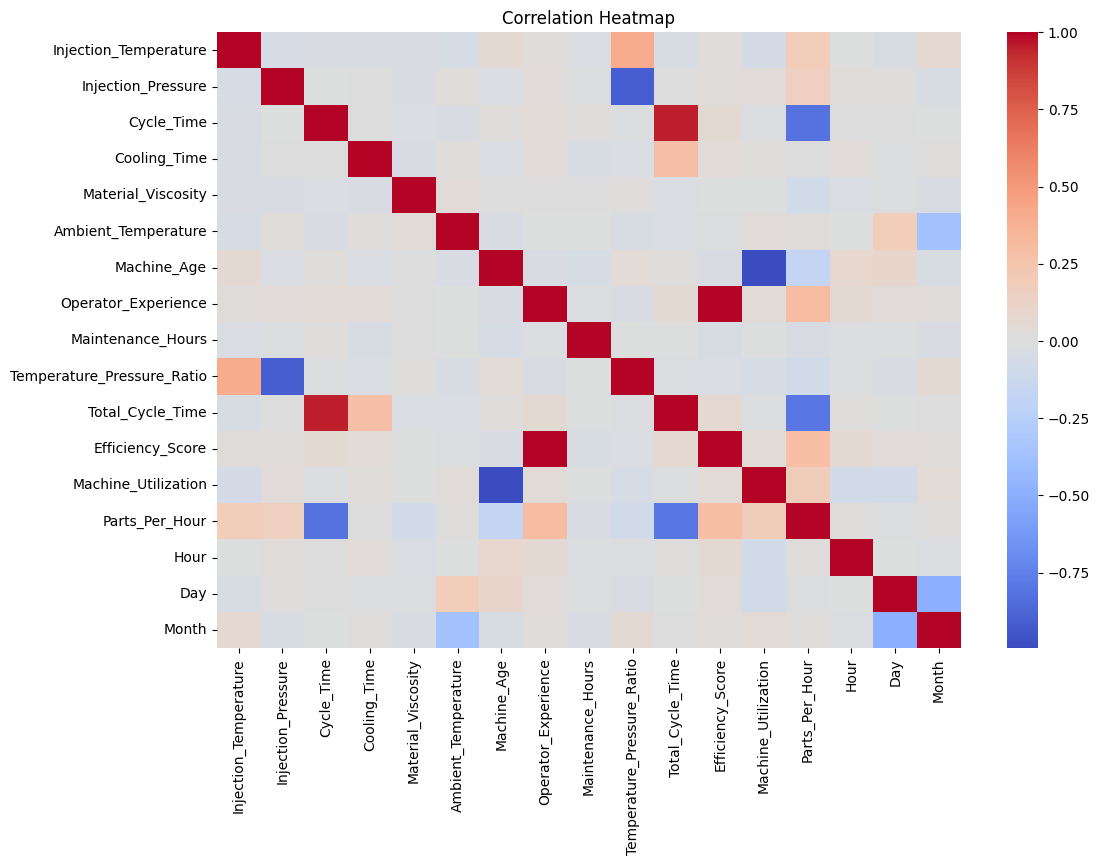

In [13]:
# 4. Basic EDA
# Target variable distribution
sns.histplot(df['Parts_Per_Hour'], kde=True, bins=30)
plt.title("Distribution of Parts Per Hour")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

In [14]:
# 5. Feature Setup
target = "Parts_Per_Hour"
X = df.drop(columns=[target])
y = df[target]

# Categorical vs Numerical features
categorical_features = ['Shift', 'Machine_Type', 'Material_Grade', 'Day_of_Week']
numerical_features = [col for col in X.columns if col not in categorical_features]

print("Categorical:", categorical_features)
print("Numerical:", numerical_features)

Categorical: ['Shift', 'Machine_Type', 'Material_Grade', 'Day_of_Week']
Numerical: ['Injection_Temperature', 'Injection_Pressure', 'Cycle_Time', 'Cooling_Time', 'Material_Viscosity', 'Ambient_Temperature', 'Machine_Age', 'Operator_Experience', 'Maintenance_Hours', 'Temperature_Pressure_Ratio', 'Total_Cycle_Time', 'Efficiency_Score', 'Machine_Utilization', 'Hour', 'Day', 'Month']


In [15]:
# 6. Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # fill missing with median
    ('scaler', StandardScaler())                    # standard scaling
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # one-hot encoding
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [16]:
# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [17]:
# 8. Model Training & Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Print regression metrics"""
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")
    print("-"*40)

# Linear Regression
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])
lr_pipeline.fit(X_train, y_train)
print("Linear Regression Performance:")
evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test)

# Ridge Regression
ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Ridge())])
ridge_params = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge_pipeline, ridge_params, cv=5,
                          scoring='neg_root_mean_squared_error')
ridge_grid.fit(X_train, y_train)
print("Ridge Best Params:", ridge_grid.best_params_)
print("Ridge Performance:")
evaluate_model(ridge_grid.best_estimator_, X_train, y_train, X_test, y_test)

# Lasso Regression
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', Lasso(max_iter=10000))])
lasso_params = {'regressor__alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso_pipeline, lasso_params, cv=5,
                          scoring='neg_root_mean_squared_error')
lasso_grid.fit(X_train, y_train)
print("Lasso Best Params:", lasso_grid.best_params_)
print("Lasso Performance:")
evaluate_model(lasso_grid.best_estimator_, X_train, y_train, X_test, y_test)

Linear Regression Performance:
RMSE: 3.5106
MAE : 2.7276
R²  : 0.9056
----------------------------------------
Ridge Best Params: {'regressor__alpha': 0.01}
Ridge Performance:
RMSE: 3.5106
MAE : 2.7276
R²  : 0.9056
----------------------------------------
Lasso Best Params: {'regressor__alpha': 0.01}
Lasso Performance:
RMSE: 3.4988
MAE : 2.7292
R²  : 0.9062
----------------------------------------


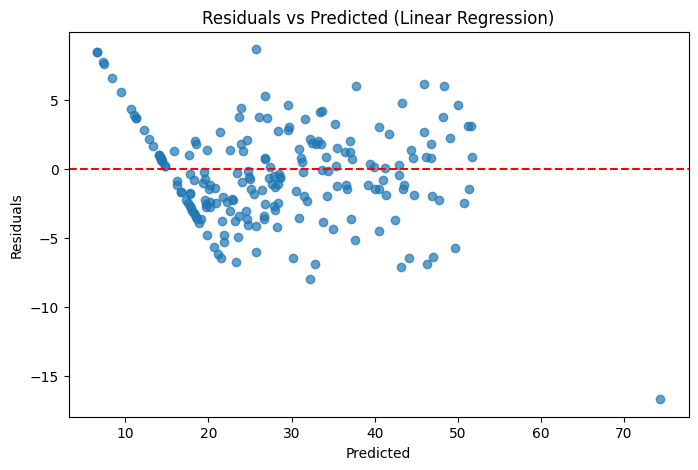

In [18]:
# 9. Residual Plot (for Linear Regression)
y_pred = lr_pipeline.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Linear Regression)")
plt.show()